In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers,Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/ctscan',shuffle=True,batch_size=32, image_size=(224,224),)

Found 2481 files belonging to 2 classes.


In [ ]:
len(dataset)

78

In [ ]:
for image_batch, labels_batch in dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [ ]:
class_names=dataset.class_names

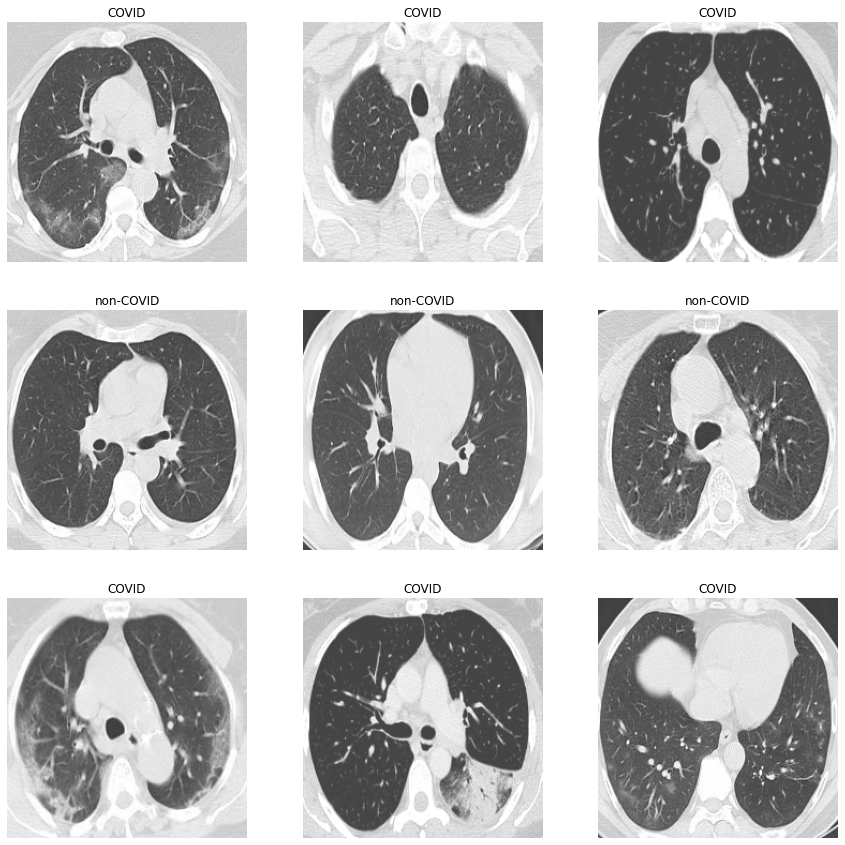

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
resize_and_rescale= tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(244,244),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
dataset=dataset.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
def train_test_split(dataset, train_size=0.8,val_size=0.1,test_size=0.1):
  train_df=dataset.take(int(train_size*len(dataset)))
  test=dataset.skip(int(train_size*len(dataset)))
  val_df=test.take(int(val_size*len(dataset)))
  test_df=test.skip(int(val_size*len(dataset)))
  return train_df,val_df,test_df

In [ ]:
train_df,val_df,test_df=train_test_split(dataset)

In [ ]:
len(train_df),len(val_df),len(test_df)

(62, 7, 9)

In [ ]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale= tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(244,244),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_df = train_df.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
base_model=tf.keras.applications.DenseNet121( include_top=False,weights="imagenet",input_shape=(244,244,3),)

In [ ]:
x=base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# multi output
output = Dense(2,activation = 'softmax', name='root')(x)




In [ ]:
model = Model(base_model.input,output)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 250, 250, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 122, 122, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_df,batch_size=32,validation_data=val_df,verbose=1,epochs=50)

Epoch 1/50
62/62 [==============================] - 68s 719ms/step - loss: 0.8300 - accuracy: 0.7031 - val_loss: 0.5916 - val_accuracy: 0.6830
Epoch 2/50
62/62 [==============================] - 30s 477ms/step - loss: 0.5758 - accuracy: 0.7818 - val_loss: 0.4374 - val_accuracy: 0.7857
Epoch 3/50
62/62 [==============================] - 29s 475ms/step - loss: 0.5071 - accuracy: 0.7933 - val_loss: 0.3557 - val_accuracy: 0.8571
Epoch 4/50
62/62 [==============================] - 30s 475ms/step - loss: 0.4719 - accuracy: 0.7989 - val_loss: 0.3609 - val_accuracy: 0.8482
Epoch 5/50
62/62 [==============================] - 29s 475ms/step - loss: 0.4212 - accuracy: 0.8065 - val_loss: 0.3513 - val_accuracy: 0.8393
Epoch 6/50
62/62 [==============================] - 29s 474ms/step - loss: 0.4131 - accuracy: 0.8216 - val_loss: 0.3669 - val_accuracy: 0.8348
Epoch 7/50
62/62 [==============================] - 29s 472ms/step - loss: 0.3993 - accuracy: 0.8160 - val_loss: 0.3052 - val_accuracy: 0.8661

In [ ]:
final_loss, final_accuracy = model.evaluate(test_df)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

9/9 [==============================] - 17s 458ms/step - loss: 0.2124 - accuracy: 0.9158
Final Loss: 0.2123538851737976, Final Accuracy: 0.9157509207725525


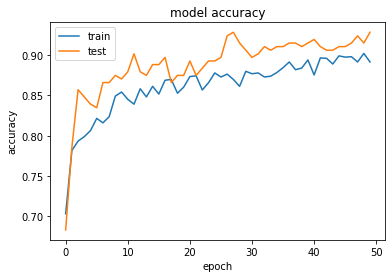

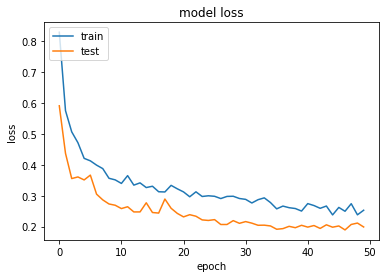

In [ ]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_df:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
confusion_matrix(predicted_labels,correct_labels)


array([[129,   6],
       [ 17, 121]])

In [ ]:
model.save('model_densenet.h5')

In [ ]:
#  x=base_model.output
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
#  x = Dense(512, activation='relu')(x)
#  x = BatchNormalization()(x)
#  x = Dropout(0.5)(x)
#  x = Dense(256, activation='relu')(x)
# multi output
#  output = Dense(1,activation = 'softmax', name='root')(x)